# 선형대수학의 기초: 벡터, 기저, 그리고 선형결합 이해하기

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.font_manager as fm
import matplotlib as mpl

# 시스템에 설치된 한글 폰트 찾기
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = [f for f in font_list if 'Gothic' in f or 'Malgun' in f or 'Nanum' in f or 'Gulim' in f]

# 한글 폰트 설정 (발견된 폰트 중 하나 선택)
if korean_fonts:
    plt.rcParams['font.family'] = korean_fonts[0]
else:
    print("한글 폰트를 찾을 수 없습니다. 폰트를 설치해 주세요.")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
# 수학 기호 깨짐 방지 
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# 3D 화살표를 그리기 위한 클래스 정의 (개선된 버전)
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# 벡터 스타일 상수 정의 (시각적 일관성을 위해)
BASIS_VECTOR_WIDTH = 0.01     # 기저 벡터는 매우 두껍게
MAIN_VECTOR_WIDTH = 0.006     # 주요 벡터는 중간 두께
DERIVED_VECTOR_WIDTH = 0.003  # 파생 벡터는 얇게

# 기저 벡터 색상 (더 진하고 풍부한 색상)
BASIS_RED = '#8B0000'      # 진한 빨강 (Dark Red)
BASIS_GREEN = '#006400'    # 진한 초록 (Dark Green)
BASIS_BLUE = '#00008B'     # 진한 파랑 (Dark Blue)
BASIS_PURPLE = '#4B0082'   # 진한 보라 (Indigo)
BASIS_ORANGE = '#FF8C00'   # 진한 주황 (Dark Orange)

# 2D 벡터를 화살표로 그리는 함수 (개선된 버전)
def plot_vector2d(vector, origin=[0, 0], color='b', label=None, width=0.005, 
                  linestyle=None, alpha=1.0, is_basis=False, zorder=None):
    """
    2D 벡터를 화살표로 그리는 함수
    
    Parameters:
    -----------
    vector: 그릴 벡터
    origin: 벡터의 시작점
    color: 화살표 색상
    label: 벡터 레이블
    width: 화살표 두께
    linestyle: 선 스타일
    alpha: 투명도
    is_basis: 기저 벡터 여부 (True이면 강조됨)
    zorder: 그리기 순서 (높을수록 앞에 그려짐)
    """
    # 기저 벡터인 경우 자동으로 두께 증가 및 zorder 설정
    if is_basis and width == 0.005:  # 기본값일 경우만 조정
        width = BASIS_VECTOR_WIDTH
    
    # zorder가 설정되지 않았으면, 기저 벡터는 앞에 표시
    if zorder is None:
        zorder = 3 if is_basis else 2
    
    plt.quiver(origin[0], origin[1], vector[0], vector[1], 
               angles='xy', scale_units='xy', scale=1, color=color, 
               width=width, label=label, linestyles=linestyle if linestyle else 'solid', 
               alpha=alpha, zorder=zorder)

# 3D 벡터를 화살표로 그리는 함수 (개선된 버전)
def plot_vector3d(ax, vector, origin=[0, 0, 0], color='b', label=None, is_basis=False):
    """
    3D 벡터를 화살표로 그리는 함수
    
    Parameters:
    -----------
    ax: 3D 축 객체
    vector: 그릴 벡터
    origin: 벡터의 시작점
    color: 화살표 색상
    label: 벡터 레이블
    is_basis: 기저 벡터 여부 (True이면 강조됨)
    """
    # 기저 벡터와 일반 벡터의 스타일 차별화
    if is_basis:
        lw = 3            # 선 두께
        ms = 25           # 화살표 크기
        arrowstyle = '-|>' # 화살표 스타일
    else:
        lw = 1.5
        ms = 15
        arrowstyle = '->'
    
    a = Arrow3D([origin[0], origin[0]+vector[0]], 
                [origin[1], origin[1]+vector[1]], 
                [origin[2], origin[2]+vector[2]], 
                mutation_scale=ms, lw=lw, arrowstyle=arrowstyle, color=color)
    ax.add_artist(a)
    
    if label:
        # 기저 벡터의 레이블은 더 크고 진하게
        fontweight = 'bold' if is_basis else 'normal'
        fontsize = 12 if is_basis else 10
        ax.text(origin[0]+vector[0]*1.1, origin[1]+vector[1]*1.1, 
                origin[2]+vector[2]*1.1, label, fontweight=fontweight, fontsize=fontsize)

## 1. 벡터 좌표와 기저 벡터

선형대수학에서는 벡터를 숫자의 나열로 표현합니다. 2차원 공간에서 벡터는 순서쌍 (x, y)로 표현됩니다. 이 좌표는 단순한 숫자 쌍이 아니라,'기저 벡터'의 스칼라 배로 해석할 수 있습니다.

표준 좌표계에서는 두 가지 특별한 벡터가 있습니다:
- **i-hat(î)**: x축 방향의 단위 벡터 (1, 0)
- **j-hat(ĵ)**: y축 방향의 단위 벡터 (0, 1)

예를 들어, 벡터 (3, -2)는 다음과 같이 해석할 수 있습니다.
- x 좌표 3은 î를 3배 늘린 것
- y 좌표 -2는 ĵ를 뒤집고 2배 늘린 것

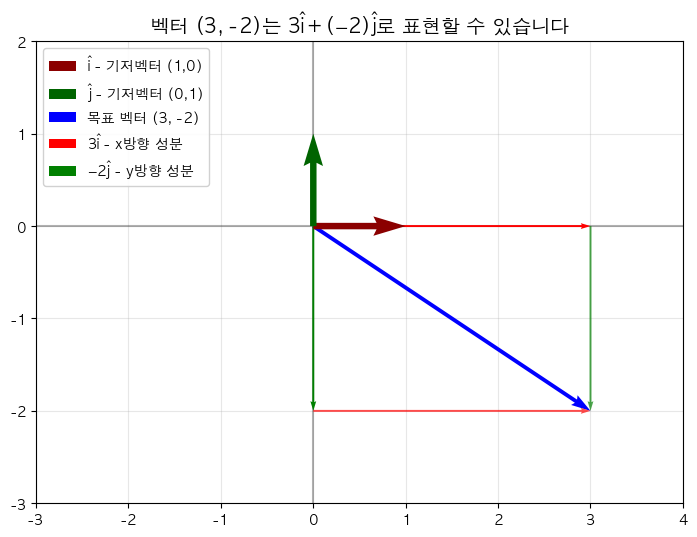

In [33]:
def plot_vector_coordinates():
    plt.figure(figsize=(10, 6))
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # 기저 벡터 그리기 (굵은 화살표로 표시)
    i_hat = np.array([1, 0])
    j_hat = np.array([0, 1])
    plot_vector2d(i_hat, color=BASIS_RED, label=r'$\hat{i}$ - 기저벡터 (1,0)', is_basis=True)
    plot_vector2d(j_hat, color=BASIS_GREEN, label=r'$\hat{j}$ - 기저벡터 (0,1)', is_basis=True)

    # 예제 벡터 (3, -2)
    vec = np.array([3, -2])
    plot_vector2d(vec, color='blue', label='목표 벡터 (3, -2)', width=MAIN_VECTOR_WIDTH)

    # 스칼라 배 벡터 그리기 (더 가는 화살표와 다른 색조로 표시)
    scaled_i = 3 * i_hat
    scaled_j = -2 * j_hat
    plot_vector2d(scaled_i, color='red', label=r'$3\hat{i}$ - x방향 성분', width=DERIVED_VECTOR_WIDTH)
    plot_vector2d(scaled_j, color='green', label=r'$-2\hat{j}$ - y방향 성분', width=DERIVED_VECTOR_WIDTH)

    # 스칼라 배 벡터의 합 그리기 (평행사변형 방법) - 점선으로 표시
    plot_vector2d(scaled_j, origin=scaled_i, color='green', width=DERIVED_VECTOR_WIDTH, linestyle='--', alpha=0.7)
    plot_vector2d(scaled_i, origin=scaled_j, color='red', width=DERIVED_VECTOR_WIDTH, linestyle='--', alpha=0.7)

    # 그리드, 레이블, 범례 설정
    plt.grid(alpha=0.3)
    plt.xlim(-3, 4)
    plt.ylim(-3, 2)
    plt.title(r'벡터 (3, -2)는 $3\hat{i} + (-2)\hat{j}$로 표현할 수 있습니다', fontsize=14)
    plt.legend(loc='upper left', framealpha=0.9)
    plt.gca().set_aspect('equal')
    plt.show()

plot_vector_coordinates()

## 2. 다른 기저 벡터로 새로운 좌표계를 만들 수 있다. 

좌표계의 기저 벡터로 반드시 î와 ĵ만 사용할 필요는 없습니다. 다른 두 벡터를 기저로 삼아 새로운 좌표계를 만들 수 있습니다. 
이런 다른 기저를 사용하면 같은 벡터도 다른 좌표로 표현됩니다.

예를 들어, 다음과 같은 두 벡터를 새로운 기저로 사용해 봅시다.
- **v₁**: (2, 1)
- **v₂**: (1, -1)

이 기저에서 (3, -2)는 어떻게 표현될까요? 이를 시각화해 봅시다.

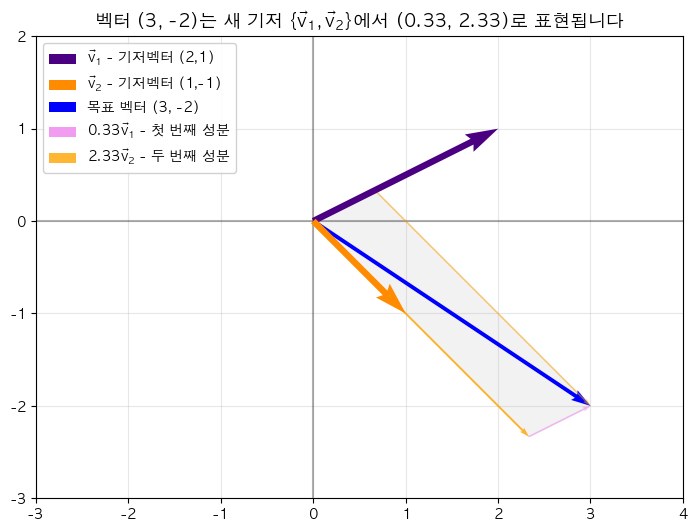

In [35]:
def plot_alternative_basis():
    # 수학 표기법 설정
    mpl.rcParams['mathtext.default'] = 'regular'

    plt.figure(figsize=(10, 6))
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # 새로운 기저 벡터 - 더 굵게, 더 진한 색상으로 표시
    v1 = np.array([2, 1])
    v2 = np.array([1, -1])
    plot_vector2d(v1, color=BASIS_PURPLE, label=r'$\vec{v}_1$ - 기저벡터 (2,1)', is_basis=True)
    plot_vector2d(v2, color=BASIS_ORANGE, label=r'$\vec{v}_2$ - 기저벡터 (1,-1)', is_basis=True)

    # 예제 벡터 (3, -2) - 중간 굵기로 표시
    vec = np.array([3, -2])
    plot_vector2d(vec, color='blue', label='목표 벡터 (3, -2)', width=MAIN_VECTOR_WIDTH)

    # 새 기저에서의 좌표 계산 (선형방정식 풀기)
    # a*v1 + b*v2 = vec 를 풀어서 a, b 찾기
    A = np.column_stack((v1, v2))
    coords = np.linalg.solve(A, vec)
    a, b = coords

    # 새 기저에서의 스칼라 배 벡터 그리기 - 더 얇고 약간 투명하게
    scaled_v1 = a * v1
    scaled_v2 = b * v2
    plot_vector2d(scaled_v1, color='violet', label=r'$%.2f\vec{v}_1$ - 첫 번째 성분' % a, 
                 width=DERIVED_VECTOR_WIDTH, alpha=0.8)
    plot_vector2d(scaled_v2, color='orange', label=r'$%.2f\vec{v}_2$ - 두 번째 성분' % b, 
                 width=DERIVED_VECTOR_WIDTH, alpha=0.8)

    # 스칼라 배 벡터의 합 그리기 (평행사변형 방법) - 가장 얇고 더 투명하게
    plot_vector2d(scaled_v2, origin=scaled_v1, color='orange', 
                 width=DERIVED_VECTOR_WIDTH*0.8, alpha=0.5, linestyle='--')
    plot_vector2d(scaled_v1, origin=scaled_v2, color='violet', 
                 width=DERIVED_VECTOR_WIDTH*0.8, alpha=0.5, linestyle='--')

    # 평행사변형 영역 색상 추가 (선택사항)
    xs = [0, scaled_v1[0], scaled_v1[0]+scaled_v2[0], scaled_v2[0], 0]
    ys = [0, scaled_v1[1], scaled_v1[1]+scaled_v2[1], scaled_v2[1], 0]
    plt.fill(xs, ys, alpha=0.1, color='gray')

    plt.grid(alpha=0.3)
    plt.xlim(-3, 4)
    plt.ylim(-3, 2)
    plt.title(r'벡터 (3, -2)는 새 기저 $\{\vec{v}_1, \vec{v}_2\}$에서 (%.2f, %.2f)로 표현됩니다' % (a, b), fontsize=13)
    plt.legend(loc='upper left', framealpha=0.9)
    plt.gca().set_aspect('equal')
    plt.show()

plot_alternative_basis()

## 3. 선형결합과 선형성

두 벡터의 **선형결합(linear combination)**은 각 벡터를 스칼라로 곱한 후 더한 결과입니다. 수학적으로 표현하면:

$$a\vec{v} + b\vec{w}$$

여기서 $a$와 $b$는 스칼라(실수)입니다.


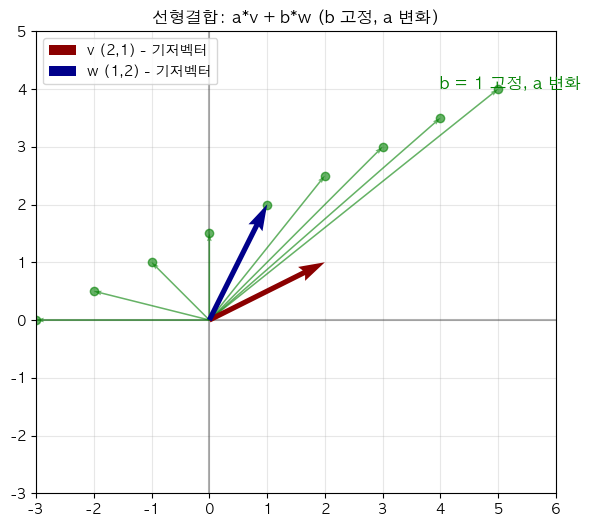

In [36]:
def plot_linear_combination_fixed_b():
    plt.figure(figsize=(10, 6))
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # 두 벡터 정의
    v = np.array([2, 1])
    w = np.array([1, 2])
    # 기저벡터로 강조
    plot_vector2d(v, color=BASIS_RED, label='v (2,1) - 기저벡터', is_basis=True)
    plot_vector2d(w, color=BASIS_BLUE, label='w (1,2) - 기저벡터', is_basis=True)

    # b 고정, a 변화
    b = 1
    for a in np.linspace(-2, 2, 9):
        result = a*v + b*w
        plot_vector2d(result, color='green', width=DERIVED_VECTOR_WIDTH, alpha=0.6)
        plt.plot(result[0], result[1], 'go', alpha=0.6)

    # 설명을 위한 텍스트
    plt.text(4, 4, f'b = {b} 고정, a 변화', fontsize=12, color='green')

    plt.grid(alpha=0.3)
    plt.xlim(-3, 6)
    plt.ylim(-3, 5)
    plt.title('선형결합: a*v + b*w (b 고정, a 변화)')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')
    plt.show()

plot_linear_combination_fixed_b()

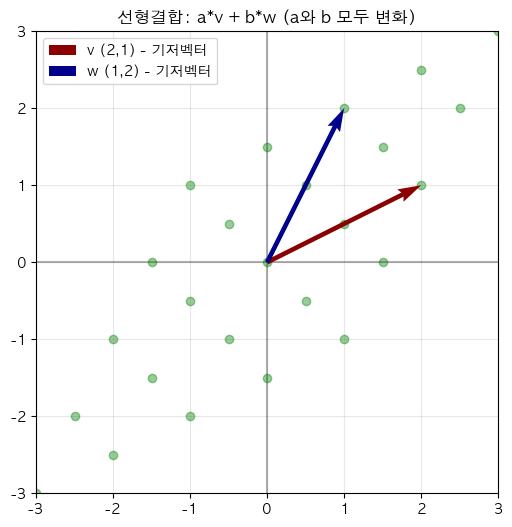

In [37]:
def plot_linear_combination_grid():
    plt.figure(figsize=(10, 6))
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # 두 벡터 정의
    v = np.array([2, 1])
    w = np.array([1, 2])
    # 기저벡터로 강조
    plot_vector2d(v, color=BASIS_RED, label='v (2,1) - 기저벡터', is_basis=True)
    plot_vector2d(w, color=BASIS_BLUE, label='w (1,2) - 기저벡터', is_basis=True)

    # a와 b 모두 변화
    for a in np.linspace(-1, 1, 5):
        for b in np.linspace(-1, 1, 5):
            result = a*v + b*w
            plt.plot(result[0], result[1], 'go', alpha=0.4)

    plt.grid(alpha=0.3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('선형결합: a*v + b*w (a와 b 모두 변화)')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')
    plt.show()

plot_linear_combination_grid()

## 4. Span 개념

벡터들의 **span**은 이 벡터들의 모든 가능한 선형결합으로 만들 수 있는 벡터들의 집합입니다. 쉽게 말해, 주어진 벡터들로 "도달할 수 있는" 모든 벡터입니다.

2차원 공간에서는 세 가지 경우가 있습니다:
1. 두 벡터가 선형 독립(같은 방향이 아님): span은 전체 2차원 평면
2. 두 벡터가 선형 종속(같은 방향): span은 원점을 지나는 직선
3. 두 벡터 모두 영벡터: span은 원점만

이를 시각화해 봅시다:

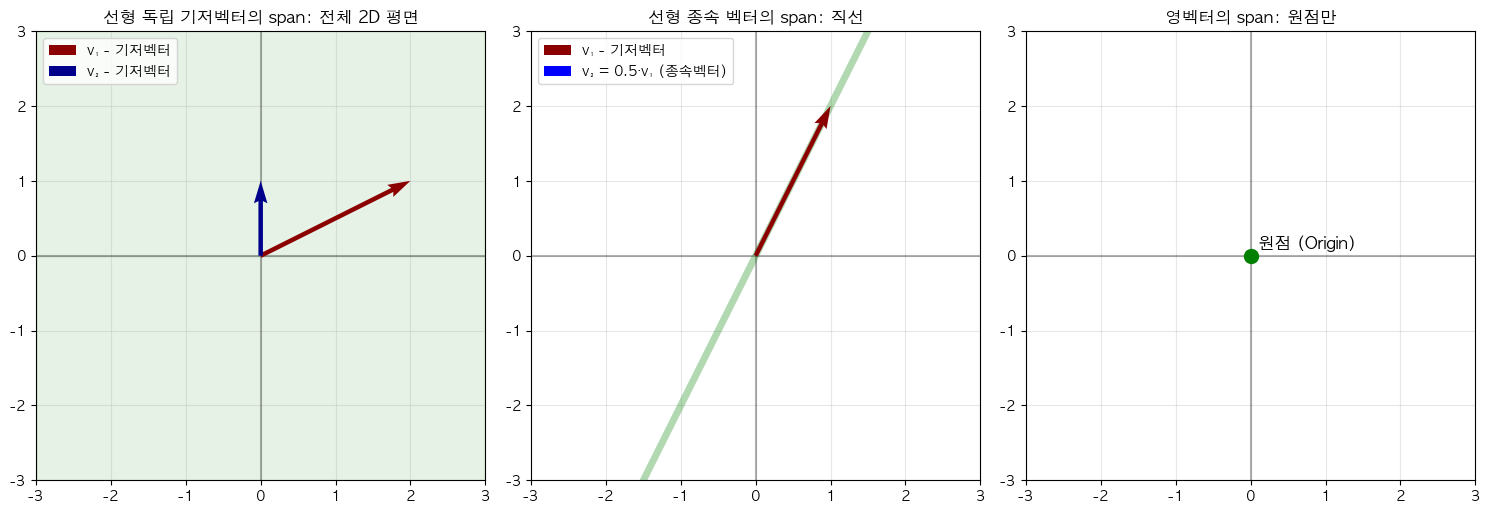

In [38]:
def plot_span_concepts():
    plt.figure(figsize=(15, 5))

    # 첫 번째 케이스: 선형 독립 벡터
    plt.subplot(1, 3, 1)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    v1 = np.array([2, 1])
    v2 = np.array([0, 1])
    # 기저벡터로 강조
    plot_vector2d(v1, color=BASIS_RED, label='v₁ - 기저벡터', is_basis=True)
    plot_vector2d(v2, color=BASIS_BLUE, label='v₂ - 기저벡터', is_basis=True)

    # 배경에 span 표시 (2차원 평면)
    plt.fill_between([-3, 3, 3, -3, -3], [-3, -3, 3, 3, -3], alpha=0.1, color='green')

    plt.grid(alpha=0.3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('선형 독립 기저벡터의 span: 전체 2D 평면')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')

    # 두 번째 케이스: 선형 종속 벡터
    plt.subplot(1, 3, 2)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    v1 = np.array([1, 2])
    v2 = np.array([0.5, 1])  # v1의 스칼라 배
    # 독립 벡터만 기저벡터로 강조
    plot_vector2d(v1, color=BASIS_RED, label='v₁ - 기저벡터', is_basis=True)
    plot_vector2d(v2, color='blue', label='v₂ = 0.5·v₁ (종속벡터)', width=DERIVED_VECTOR_WIDTH)

    # 직선으로 span 표시
    t = np.linspace(-2, 2, 100)
    line_x = t * v1[0]
    line_y = t * v1[1]
    plt.plot(line_x, line_y, color='green', alpha=0.3, linewidth=5)

    plt.grid(alpha=0.3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('선형 종속 벡터의 span: 직선')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')

    # 세 번째 케이스: 영벡터
    plt.subplot(1, 3, 3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # 영벡터는 표시하지 않음 (보이지 않으므로)
    
    # 원점 강조
    plt.plot(0, 0, 'go', markersize=10)
    plt.text(0.1, 0.1, '원점 (Origin)', fontsize=12)

    plt.grid(alpha=0.3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('영벡터의 span: 원점만')
    plt.gca().set_aspect('equal')

    plt.tight_layout()
    plt.show()

plot_span_concepts()

## 5. 벡터를 점으로 시각화하기

많은 벡터들을 다룰 때는 각 벡터를 화살표가 아닌 점으로 표현하면 훨씬 깔끔하게 시각화할 수 있습니다. 각 벡터를 원점에서 시작하는 화살표로 생각했을 때, 그 화살표의 끝점이 벡터를 대표합니다.

이렇게 하면:
- 직선 위에 있는 벡터들의 집합은 직선으로 표현
- 평면 위에 있는 벡터들의 집합은 평면으로 표현
- 3차원 공간의 벡터들의 집합은 3차원 공간으로 표현

다음 시각화에서는 여러 선형결합으로 생성된 벡터들을 점으로 표현해 보겠습니다.

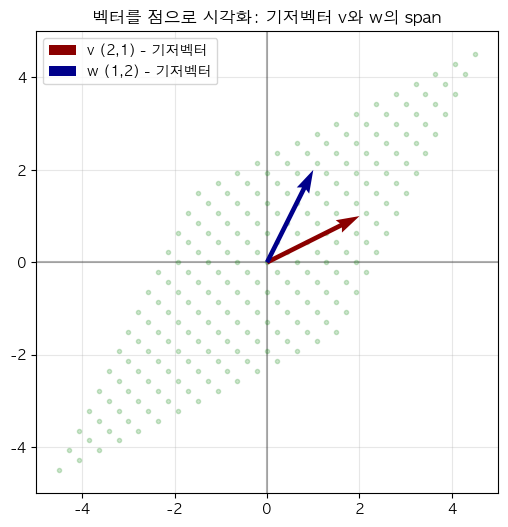

In [39]:
def plot_vectors_as_points():
    plt.figure(figsize=(10, 6))
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # 두 기저벡터 정의
    v = np.array([2, 1])
    w = np.array([1, 2])
    # 기저벡터로 강조
    plot_vector2d(v, color=BASIS_RED, label='v (2,1) - 기저벡터', is_basis=True)
    plot_vector2d(w, color=BASIS_BLUE, label='w (1,2) - 기저벡터', is_basis=True)

    # 많은 선형결합 생성하고 점으로 표시
    a_values = np.linspace(-1.5, 1.5, 15)
    b_values = np.linspace(-1.5, 1.5, 15)

    for a in a_values:
        for b in b_values:
            result = a*v + b*w
            plt.plot(result[0], result[1], 'go', alpha=0.2, markersize=3)

    plt.grid(alpha=0.3)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.title('벡터를 점으로 시각화: 기저벡터 v와 w의 span')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')
    plt.show()
    
plot_vectors_as_points()

## 6. 3차원 공간에서의 Span

3차원 공간에서는 span의 개념이 더욱 흥미로워집니다. 서로 다른 방향을 가리키는 두 벡터의 span은 원점을 지나는 평면입니다. 만약 세 번째 벡터가 이 평면에 없다면, 세 벡터의 span은 전체 3차원 공간이 됩니다.


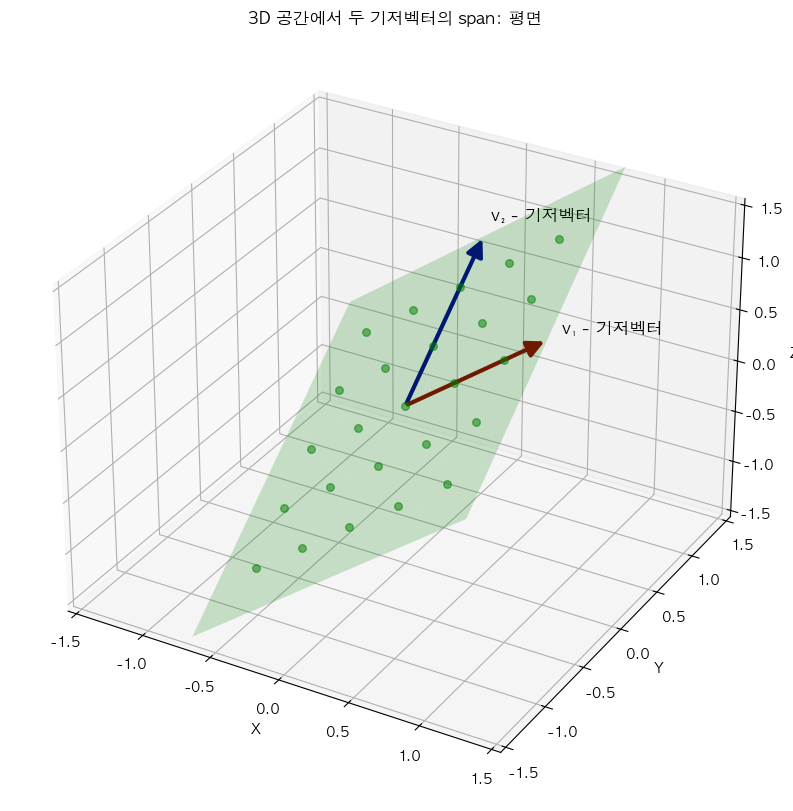

In [40]:
# 3D 공간에서 두 벡터의 span (평면)
def plot_3d_span_plane():
    # 3D 공간에서 두 벡터의 span (평면)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 두 벡터 정의
    v1 = np.array([1, 0, 1])
    v2 = np.array([0, 1, 1])

    # 기저벡터로 강조하여 그리기
    plot_vector3d(ax, v1, color=BASIS_RED, label='v₁ - 기저벡터', is_basis=True)
    plot_vector3d(ax, v2, color=BASIS_BLUE, label='v₂ - 기저벡터', is_basis=True)

    # span 시각화 (평면)
    xx, yy = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
    z = np.zeros_like(xx)

    # 평면 방정식 계산 (v1과 v2로 정의된 평면)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = xx[i,j] * v1 + yy[i,j] * v2
            z[i,j] = point[2]

    ax.plot_surface(xx, yy, z, alpha=0.2, color='green')

    # 평면 위의 점들 (선형결합으로 만들어진 벡터들)
    for a in np.linspace(-0.7, 0.7, 5):
        for b in np.linspace(-0.7, 0.7, 5):
            point = a*v1 + b*v2
            ax.scatter(point[0], point[1], point[2], color='g', alpha=0.5, s=30)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D 공간에서 두 기저벡터의 span: 평면')
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    plt.show()
plot_3d_span_plane()

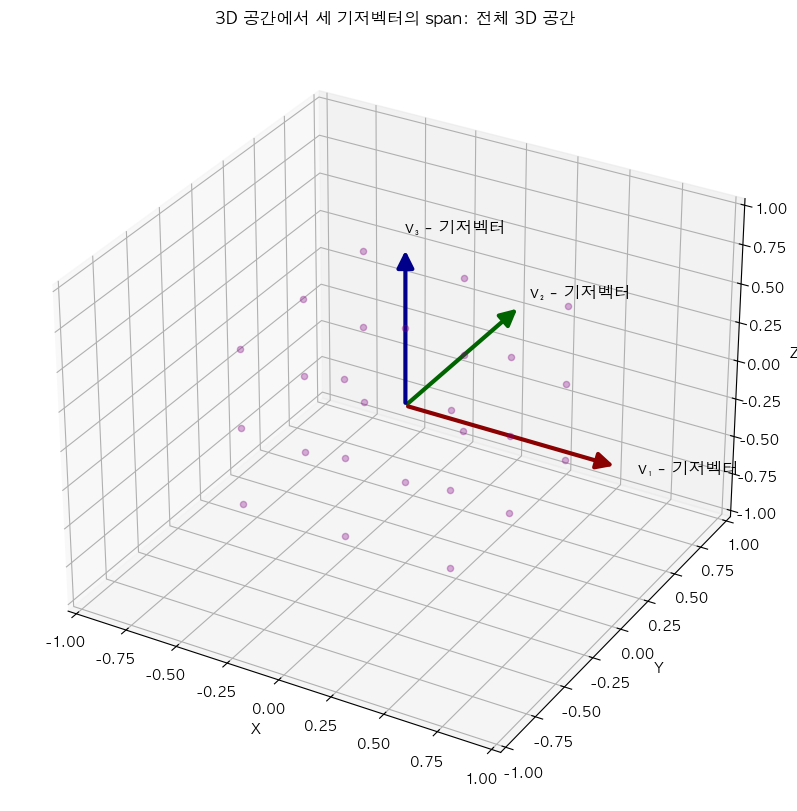

In [41]:
# 3D 공간에서 세 벡터의 span (전체 공간)
def plot_3d_span_space():
    # 3D 공간에서 세 벡터의 span (전체 공간)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 세 벡터 정의 (선형 독립)
    v1 = np.array([1, 0, 0])
    v2 = np.array([0, 1, 0])
    v3 = np.array([0, 0, 1])

    # 기저벡터로 강조하여 그리기
    plot_vector3d(ax, v1, color=BASIS_RED, label='v₁ - 기저벡터', is_basis=True)
    plot_vector3d(ax, v2, color=BASIS_GREEN, label='v₂ - 기저벡터', is_basis=True)
    plot_vector3d(ax, v3, color=BASIS_BLUE, label='v₃ - 기저벡터', is_basis=True)

    # 공간 내 점들 (선형결합으로 만들어진 벡터들)
    for a in np.linspace(-0.5, 0.5, 3):
        for b in np.linspace(-0.5, 0.5, 3):
            for c in np.linspace(-0.5, 0.5, 3):
                if abs(a) + abs(b) + abs(c) > 0.2:  # 원점 근처 제외
                    point = a*v1 + b*v2 + c*v3
                    ax.scatter(point[0], point[1], point[2], color='purple', alpha=0.3, s=20)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D 공간에서 세 기저벡터의 span: 전체 3D 공간')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    plt.show()

plot_3d_span_space()

## 7. 선형 독립성과 선형 종속성

벡터 집합이 **선형 종속(linearly dependent)**이라는 것은 집합의 적어도 하나의 벡터가 다른 벡터들의 선형결합으로 표현될 수 있다는 의미입니다. 다시 말해, 적어도 하나의 벡터가 "중복"되어 있어서 span에 새로운 차원을 추가하지 않습니다.

반대로, 벡터 집합이 **선형 독립(linearly independent)**이라는 것은 집합의 어떤 벡터도 다른 벡터들의 선형결합으로 표현될 수 없다는 의미입니다. 각 벡터는 span에 새로운 차원을 추가합니다.

선형 종속성을 시각화해 봅시다:

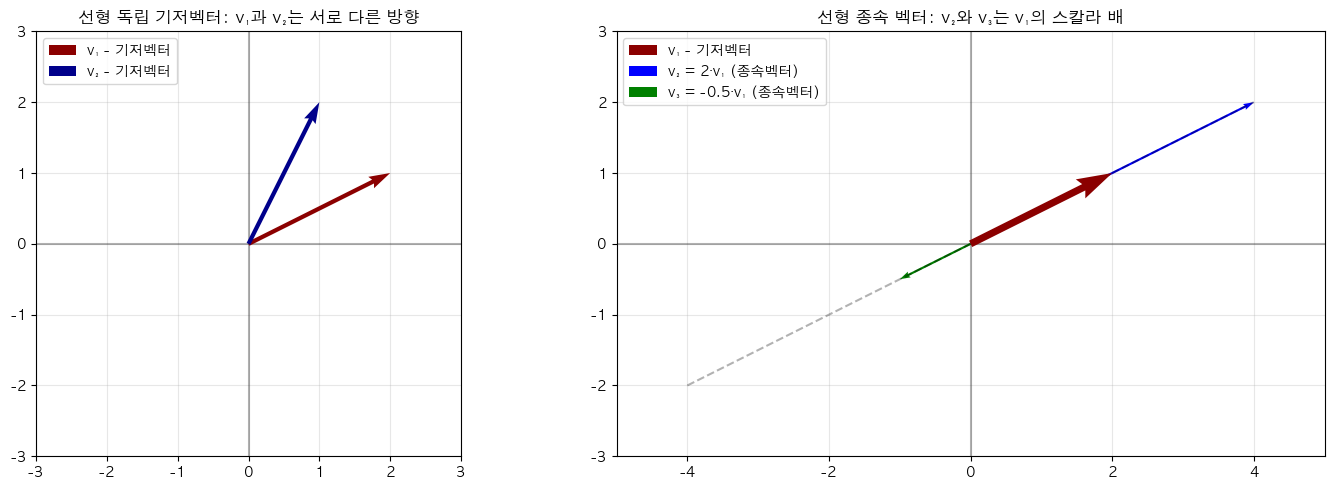

In [42]:
def plot_linear_independence():
    plt.figure(figsize=(15, 5))

    # 선형 독립 벡터
    plt.subplot(1, 2, 1)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    v1 = np.array([2, 1])
    v2 = np.array([1, 2])
    # 기저벡터로 강조
    plot_vector2d(v1, color=BASIS_RED, label='v₁ - 기저벡터', is_basis=True)
    plot_vector2d(v2, color=BASIS_BLUE, label='v₂ - 기저벡터', is_basis=True)

    plt.grid(alpha=0.3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('선형 독립 기저벡터: v₁과 v₂는 서로 다른 방향', fontweight='bold')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')

    # 선형 종속 벡터
    plt.subplot(1, 2, 2)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    v1 = np.array([2, 1])
    v2 = np.array([4, 2])  # v1의 2배
    v3 = np.array([-1, -0.5])  # v1의 -0.5배

    # 첫 번째만 기저벡터로 강조
    plot_vector2d(v1, color=BASIS_RED, label='v₁ - 기저벡터', is_basis=True)
    plot_vector2d(v2, color='blue', label='v₂ = 2·v₁ (종속벡터)', width=DERIVED_VECTOR_WIDTH)
    plot_vector2d(v3, color='green', label='v₃ = -0.5·v₁ (종속벡터)', width=DERIVED_VECTOR_WIDTH)

    # v1의 스칼라 배를 나타내는 직선
    t = np.linspace(-2, 2, 100)
    line_x = t * v1[0]
    line_y = t * v1[1]
    plt.plot(line_x, line_y, 'k--', alpha=0.3)

    plt.grid(alpha=0.3)
    plt.xlim(-5, 5)
    plt.ylim(-3, 3)
    plt.title('선형 종속 벡터: v₂와 v₃는 v₁의 스칼라 배', fontweight='bold')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')

    plt.tight_layout()
    plt.show()

plot_linear_independence()

## 8. 기저의 기술적 정의

이제 기저의 기술적 정의를 살펴볼 준비가 되었습니다. 벡터 공간의 **기저(basis)**는 다음 두 조건을 만족하는 벡터 집합입니다:

1. 벡터들이 **선형 독립**이다.
2. 벡터들이 전체 공간을 **span**한다.

쉽게 말해, 기저는 "공간을 효율적으로 생성하는 최소한의 벡터 집합"입니다.

n차원 공간의 기저는 항상 정확히 n개의 벡터로 구성됩니다. 예를 들어:
- 2차원 평면의 기저: 2개의 선형 독립 벡터
- 3차원 공간의 기저: 3개의 선형 독립 벡터

표준 기저는 각 차원에 하나씩 단위 벡터를 포함합니다:
- 2차원: {(1,0), (0,1)}
- 3차원: {(1,0,0), (0,1,0), (0,0,1)}

다음 시각화는 2차원 공간의 표준 기저와 대안적 기저를 비교합니다:

/var/folders/xb/__28chrd3wz6fnp5z7j4wk700000gp/T/ipykernel_24498/1927807496.py:54: UserWarning: Glyph 238 (\N{LATIN SMALL LETTER I WITH CIRCUMFLEX}) missing from current font.
  plt.tight_layout()
/var/folders/xb/__28chrd3wz6fnp5z7j4wk700000gp/T/ipykernel_24498/1927807496.py:54: UserWarning: Glyph 309 (\N{LATIN SMALL LETTER J WITH CIRCUMFLEX}) missing from current font.
  plt.tight_layout()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 238 (\N{LATIN SMALL LETTER I WITH CIRCUMFLEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 309 (\N{LATIN SMALL LETTER J WITH CIRCUMFLEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


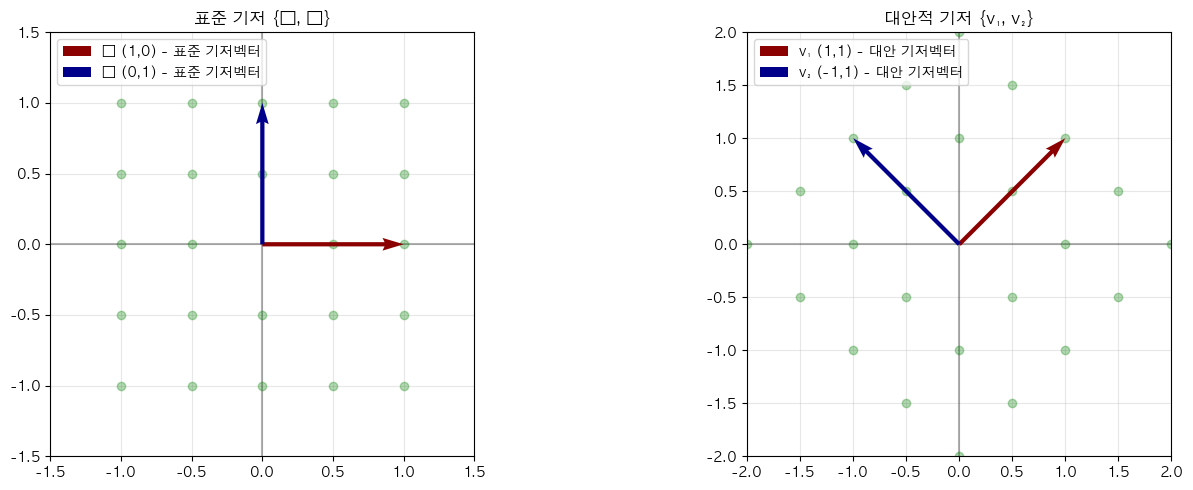

In [43]:
def plot_basis_definition():
    plt.figure(figsize=(15, 5))

    # 표준 기저
    plt.subplot(1, 2, 1)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    i_hat = np.array([1, 0])
    j_hat = np.array([0, 1])
    # 기저벡터로 강조
    plot_vector2d(i_hat, color=BASIS_RED, label='î (1,0) - 표준 기저벡터', is_basis=True)
    plot_vector2d(j_hat, color=BASIS_BLUE, label='ĵ (0,1) - 표준 기저벡터', is_basis=True)

    # 표준 기저로 표현된 벡터들
    for x in np.linspace(-1, 1, 5):
        for y in np.linspace(-1, 1, 5):
            if abs(x) + abs(y) > 0.2:  # 원점 근처 제외
                vec = x*i_hat + y*j_hat
                plt.plot(vec[0], vec[1], 'go', alpha=0.3)

    plt.grid(alpha=0.3)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title('표준 기저 {î, ĵ}', fontweight='bold')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')

    # 대안 기저
    plt.subplot(1, 2, 2)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    v1 = np.array([1, 1])
    v2 = np.array([-1, 1])
    # 기저벡터로 강조
    plot_vector2d(v1, color=BASIS_RED, label='v₁ (1,1) - 대안 기저벡터', is_basis=True)
    plot_vector2d(v2, color=BASIS_BLUE, label='v₂ (-1,1) - 대안 기저벡터', is_basis=True)

    # 대안 기저로 표현된 벡터들
    for a in np.linspace(-1, 1, 5):
        for b in np.linspace(-1, 1, 5):
            if abs(a) + abs(b) > 0.2:  # 원점 근처 제외
                vec = a*v1 + b*v2
                plt.plot(vec[0], vec[1], 'go', alpha=0.3)

    plt.grid(alpha=0.3)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title('대안적 기저 {v₁, v₂}', fontweight='bold')
    plt.legend(loc='upper left')
    plt.gca().set_aspect('equal')

    plt.tight_layout()
    plt.show()

plot_basis_definition()